# Lecture 68: Text Representation Techniques

This notebook demonstrates three key **text representation techniques** used in Natural Language Processing (NLP): **Bag of Words (BoW)**, **TF-IDF**, and **Word Embeddings (Word2Vec and GloVe)**. We'll use a small sample dataset to illustrate how each method converts text into numerical features for machine learning. The notebook covers:

- Preprocessing text data
- Implementing BoW using Scikit-learn
- Implementing TF-IDF using Scikit-learn
- Training a Word2Vec model using Gensim
- Loading pre-trained GloVe embeddings using spaCy
- Comparing and visualizing the representations

These techniques are foundational for tasks like text classification, sentiment analysis, and more.

## Setup and Imports

Let's import the necessary libraries and set up the environment. You'll need to install `scikit-learn`, `nltk`, `gensim`, and `spacy`, and download a pre-trained GloVe model for spaCy.

In [4]:
%%capture
!pip install --upgrade numpy
!pip install --upgrade gensim

In [2]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 53.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import spacy
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


# Load spaCy model with GloVe embeddings
nlp = spacy.load('en_core_web_md')

# Set random seed for reproducibility
np.random.seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Sample Dataset

We'll use a small sample dataset of sentences to demonstrate the text representation techniques. These sentences are simple but diverse enough to show differences in the methods.

In [4]:
# Sample dataset
texts = [
    "The cat runs quickly in the garden.",
    "A dog walks slowly on the street.",
    "Cats and dogs play together happily.",
    "The garden is full of beautiful flowers.",
    "Streets are busy with cars and people."
]

# Display dataset
print("Sample Texts:")
for i, text in enumerate(texts, 1):
    print(f"Text {i}: {text}")

Sample Texts:
Text 1: The cat runs quickly in the garden.
Text 2: A dog walks slowly on the street.
Text 3: Cats and dogs play together happily.
Text 4: The garden is full of beautiful flowers.
Text 5: Streets are busy with cars and people.


## Text Preprocessing

We'll preprocess the text by converting to lowercase, removing special characters, tokenizing, removing stop words, and lemmatizing. This ensures consistency across all representation methods.

In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return tokens, ' '.join(tokens)

# Preprocess texts
processed_texts = []
tokenized_texts = []
for text in texts:
    tokens, processed_text = preprocess_text(text)
    tokenized_texts.append(tokens)
    processed_texts.append(processed_text)

print("\nPreprocessed Texts:")
for i, text in enumerate(processed_texts, 1):
    print(f"Text {i}: {text}")


Preprocessed Texts:
Text 1: cat run quickly garden
Text 2: dog walk slowly street
Text 3: cat dog play together happily
Text 4: garden full beautiful flower
Text 5: street busy car people


## 1. Bag of Words (BoW)

**Bag of Words** represents text as a sparse matrix of word counts or frequencies, ignoring word order and context. Each document is a vector of word occurrences.

In [6]:
# Initialize BoW vectorizer
bow_vectorizer = CountVectorizer(max_features=100)

# Fit and transform the texts
bow_matrix = bow_vectorizer.fit_transform(processed_texts)

# Convert to DataFrame for visualization
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())

print("\nBag of Words Matrix:")
print(bow_df)

# Display vocabulary
print("\nBoW Vocabulary:")
print(bow_vectorizer.vocabulary_)


Bag of Words Matrix:
   beautiful  busy  car  cat  dog  flower  full  garden  happily  people  \
0          0     0    0    1    0       0     0       1        0       0   
1          0     0    0    0    1       0     0       0        0       0   
2          0     0    0    1    1       0     0       0        1       0   
3          1     0    0    0    0       1     1       1        0       0   
4          0     1    1    0    0       0     0       0        0       1   

   play  quickly  run  slowly  street  together  walk  
0     0        1    1       0       0         0     0  
1     0        0    0       1       1         0     1  
2     1        0    0       0       0         1     0  
3     0        0    0       0       0         0     0  
4     0        0    0       0       1         0     0  

BoW Vocabulary:
{'cat': 3, 'run': 12, 'quickly': 11, 'garden': 7, 'dog': 4, 'walk': 16, 'slowly': 13, 'street': 14, 'play': 10, 'together': 15, 'happily': 8, 'full': 6, 'beautiful': 0,

## 2. TF-IDF

**Term Frequency-Inverse Document Frequency (TF-IDF)** weighs words based on their frequency in a document (TF) and rarity across the corpus (IDF), emphasizing important words.

In [7]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100)

# Fit and transform the texts
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_texts)

# Convert to DataFrame for visualization
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print("\nTF-IDF Matrix:")
print(tfidf_df)

# Display vocabulary
print("\nTF-IDF Vocabulary:")
print(tfidf_vectorizer.vocabulary_)


TF-IDF Matrix:
   beautiful      busy       car       cat       dog    flower      full  \
0   0.000000  0.000000  0.000000  0.444002  0.000000  0.000000  0.000000   
1   0.000000  0.000000  0.000000  0.000000  0.444002  0.000000  0.000000   
2   0.000000  0.000000  0.000000  0.388988  0.388988  0.000000  0.000000   
3   0.523358  0.000000  0.000000  0.000000  0.000000  0.523358  0.523358   
4   0.000000  0.523358  0.523358  0.000000  0.000000  0.000000  0.000000   

     garden  happily    people     play   quickly       run    slowly  \
0  0.444002  0.00000  0.000000  0.00000  0.550329  0.550329  0.000000   
1  0.000000  0.00000  0.000000  0.00000  0.000000  0.000000  0.550329   
2  0.000000  0.48214  0.000000  0.48214  0.000000  0.000000  0.000000   
3  0.422242  0.00000  0.000000  0.00000  0.000000  0.000000  0.000000   
4  0.000000  0.00000  0.523358  0.00000  0.000000  0.000000  0.000000   

     street  together      walk  
0  0.000000   0.00000  0.000000  
1  0.444002   0.0000

## 3. Word2Vec

**Word2Vec** is a word embedding technique that represents words as dense vectors in a continuous vector space, capturing semantic relationships. We'll train a simple Word2Vec model on our tokenized texts.

In [8]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4, seed=42)

# Function to get document embedding by averaging word vectors
def get_doc_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Get document embeddings
word2vec_embeddings = np.array([get_doc_embedding(tokens, word2vec_model) for tokens in tokenized_texts])

# Display embeddings shape
print("\nWord2Vec Document Embeddings Shape:", word2vec_embeddings.shape)

# Example: Word similarity
print("\nWord2Vec Similarity between 'cat' and 'dog':")
print(word2vec_model.wv.similarity('cat', 'dog'))


Word2Vec Document Embeddings Shape: (5, 100)

Word2Vec Similarity between 'cat' and 'dog':
-0.008360074


## 4. GloVe

**GloVe (Global Vectors)** is another word embedding technique that captures global word co-occurrence statistics. We'll use spaCy's pre-trained GloVe embeddings (`en_core_web_md`) to represent words and documents.

In [9]:
# Function to get document embedding using GloVe
def get_glove_embedding(text):
    doc = nlp(text)
    return doc.vector

# Get GloVe embeddings for each document
glove_embeddings = np.array([get_glove_embedding(text) for text in texts])

# Display embeddings shape
print("\nGloVe Document Embeddings Shape:", glove_embeddings.shape)

# Example: Cosine similarity between documents
print("\nGloVe Cosine Similarity between Text 1 and Text 2:")
cos_sim = cosine_similarity([glove_embeddings[0]], [glove_embeddings[1]])[0][0]
print(cos_sim)


GloVe Document Embeddings Shape: (5, 300)

GloVe Cosine Similarity between Text 1 and Text 2:
0.85478246


## Comparing Representations

To compare the representations, we'll visualize the document embeddings (Word2Vec and GloVe) in 2D space using PCA. BoW and TF-IDF are sparse and high-dimensional, so we'll focus on embeddings for visualization.

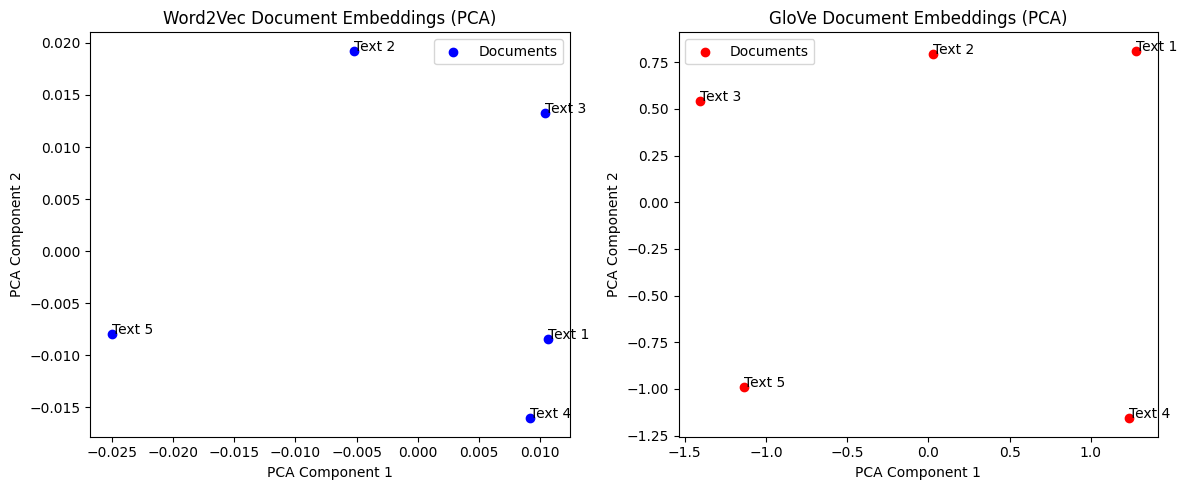

In [10]:
# Apply PCA to reduce embeddings to 2D
pca = PCA(n_components=2)
word2vec_2d = pca.fit_transform(word2vec_embeddings)
glove_2d = pca.fit_transform(glove_embeddings)

# Plot Word2Vec embeddings
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(word2vec_2d[:, 0], word2vec_2d[:, 1], c='blue', label='Documents')
for i, txt in enumerate([f'Text {i+1}' for i in range(len(texts))]):
    plt.annotate(txt, (word2vec_2d[i, 0], word2vec_2d[i, 1]))
plt.title('Word2Vec Document Embeddings (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

# Plot GloVe embeddings
plt.subplot(1, 2, 2)
plt.scatter(glove_2d[:, 0], glove_2d[:, 1], c='red', label='Documents')
for i, txt in enumerate([f'Text {i+1}' for i in range(len(texts))]):
    plt.annotate(txt, (glove_2d[i, 0], glove_2d[i, 1]))
plt.title('GloVe Document Embeddings (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

plt.tight_layout()
plt.savefig('embeddings_pca.png')

## Explanation

- **Bag of Words (BoW)**:
  - Represents text as a sparse matrix of word counts.
  - Pros: Simple, interpretable.
  - Cons: Ignores word order and semantics, high-dimensional.
- **TF-IDF**:
  - Weighs words by importance (frequency and rarity).
  - Pros: Reduces impact of common words, better than BoW for many tasks.
  - Cons: Still sparse and lacks semantic understanding.
- **Word2Vec**:
  - Dense embeddings capturing semantic relationships.
  - Pros: Captures word similarities (e.g., 'cat' and 'dog' are close).
  - Cons: Requires training, may not generalize well with small datasets.
- **GloVe**:
  - Pre-trained embeddings based on global co-occurrence.
  - Pros: Rich semantic representations, no training needed.
  - Cons: Fixed embeddings, may not adapt to domain-specific corpora.
- **Visualization**: PCA reduced Word2Vec and GloVe embeddings to 2D, showing how documents cluster based on semantic similarity.

To extend this work, consider:
- Using larger datasets for better Word2Vec training
- Fine-tuning embeddings for domain-specific tasks
- Exploring advanced embeddings like BERT or FastText
- Applying these representations to downstream tasks (e.g., classification)